***
## Table of Contents
<br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. HTTP</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Loading Data </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Feature Selection </h3></a>
            </ul>
        <ul>
            <a href='#1.C' style="text-decoration : none; color : #000000;"><h3>C. Splitting Training and Test Data For Selected Features </h3></a>
           </ul>
        <ul>
            <a href='#1.D' style="text-decoration : none; color : #000000;"><h3>D. Classification using different methods </h3></a>
            </ul>
            <ul>
            <a href='#1.E' style="text-decoration : none; color : #000000;"><h3>E. Results </h3></a>
            </ul>
     </ol>
     <br>
      <ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. HTTP with PCA</a></h2>
        <ul><a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Classification using different methods </h3></a>
            </ul>
            <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Results </h3></a>
            </ul>
            <ul>
             <a href='#2.C' style="text-decoration : none; color : #000000;"><h3> C. % variance eplained by selected features</h3> </a> </ul>
     </ol>
<br>

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pandas.io.json import json_normalize
from IPython.display import display,clear_output,HTML
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression,RandomizedLasso,LinearRegression, Ridge,Lasso
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier,VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold,GridSearchCV,train_test_split,cross_val_score

from sklearn.preprocessing import MinMaxScaler,StandardScaler,binarize
from sklearn.ensemble import RandomForestRegressor
from minepy import MINE
from sklearn import metrics

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,accuracy_score,auc,roc_curve,recall_score
from sklearn import metrics
from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [2]:
### Function get_params takes as input a grid search model and prints out the best parameters for the model and 
### prints the best accuracy of the model
def get_params(grid,model_name=''):
    print("Best Parameters are :")
    display(pd.DataFrame.from_dict(grid.best_params_, orient='index').reset_index().transpose())

### The function takes as input the model, X and Y data to generate the confusion matrix  
def get_cm(model,a,b):
    y_pred=model.predict(a)
    cm=ConfusionMatrix(b,y_pred)
    return cm
 
### The get accuracy plot takes as input a dataframe and a string for the title of the plot and displays a plot
### The function is primarily for plotting of accuracies for various classifiers for the same split.
def get_accuracy_plot(data,title=''):
    plt.figure(figsize=(12,8))
    plt.plot(data['accuracy'].values, '--o')
    plt.ylabel('Accuracy', fontsize=20)
    plt.xlabel('Classifier', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xlim([0, 9])
    plt.title(title,size=18,y=1.05)
    plt.xticks(np.arange(10),data.index.get_values(),rotation=90)
    plt.legend(loc='upper right', fontsize=18)
    plt.show()

### Function grid takes as input an estimator, X_train,Y_Train,X_test and Y_test and a string represetning the name of the model
### We perform StratifiedKFold cross validation and grid search to hypertune the parameters of the model     
def grid(kernel,params,x,y,x_test,y_test,model_name=''):
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    grid_search=GridSearchCV(estimator=kernel,param_grid=parameters,scoring='accuracy',cv=kfold,n_jobs=3,verbose=True)
    grid_search.fit(x,y)
    get_params(grid_search,model_name)
    acc_train=accuracy_score(y,grid_search.predict(x))
    print("Accuracy of the ",model_name," model for the training data is:",acc_train)
    print("\nConfusion Matrix for Training data is:")
    cm_train=get_cm(grid_search,x,y)
    display(cm_train)
    acc_test=accuracy_score(y_test,grid_search.predict(x_test))
    print("Accuracy of the ",model_name," model for test data is:",acc_test)
    print("\nConfusion Matrix for test data is:")
    cm_test=get_cm(grid_search,x_test,y_test)
    display(cm_test)
    fpr, tpr, threshold = roc_curve(y_test, grid_search.predict(x_test))
    roc_auc =auc(fpr, tpr)
    return grid_search,cm_train,cm_test,acc_train,acc_test,roc_auc  

### Plot roc curve
def get_roc_curve(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy on test data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

def get_roc_curve_deep_learning(model,x_test,y_test):
    prob=model.predict_proba(x_test)
    preds=prob
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc =auc(fpr, tpr)
    plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(threshold, index = i)})
    threshold=roc.ix[(roc.tf-0).abs().argsort()[:1]]['thresholds'].values[0]
    print("Optimal Threshold is",threshold)
    y_pred_class=binarize(preds.reshape(1,-1),threshold)[0]
    accuracy=accuracy_score(y_test,y_pred_class)
    print("Accuracy of Logistic Model on training data is:",accuracy)
    cm=ConfusionMatrix(y_test,y_pred_class)
    display(cm)
    return cm,accuracy,threshold,roc_auc

## <a id='1' style="text-decoration : none; color : #000000;"> HTTP</a>

### <a id='1.A' style="text-decoration : none; color : #000000;">A. Loading Data</a>

In [3]:
df_alex=pd.read_csv('Javascript_alexa_output_final_http.csv',low_memory=False)
df_virus=pd.read_csv('Javascript_malicious_output_final_http.csv',low_memory=False)

df_alex['Malicious']=0
df_virus['Malicious']=1

df=pd.concat([df_alex,df_virus])
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df = df.sample(frac=1,random_state=867).reset_index(drop=True)
df.fillna(value=0,inplace=True)
df=df[df['html_status']=='Success']


### Dropping columns that indicate the html status of domain data collection

df.drop(['html_status','html_status_strerror','html_status_message'],axis=1,inplace=True)
df.set_index(['domain'],inplace=True)


# df.to_csv('Javascript_dom.csv')

df.head()

df_non=df[df.Malicious==0]
df_mal=df[df.Malicious==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Malicious.value_counts() 

1    6287
0    6287
Name: Malicious, dtype: int64

In [4]:
X=df_u.copy(deep=True)

drop_col=[col for col in df_u.columns if 'number' in col]

drop_col.append('Malicious')

In [5]:
X.drop(drop_col,axis=1,inplace=True)
y=df_u.Malicious.values
feature_name = X.columns.tolist()

In [6]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)


X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()


rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=100, step=10, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()


embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()


feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [7]:
X=df_u[feature_selection_df[feature_selection_df.Total==4]['Feature']]
y=df_u.Malicious.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(12574, 69)

#### Features selected

In [8]:
feature_name

['js_function_unescape(',
 'js_function_parseInt(',
 'js_function_escape(',
 'js_function_encodeURIComponent(',
 'js_function_encodeURI(',
 'js_function_decodeURIComponent(',
 'js_function_String.fromCharCode(',
 'js_function_Object.keys(',
 'js_function_Object.getOwnPropertyNames(',
 'js_function_Math.round(',
 'js_function_Math.random(',
 'js_function_Math.min(',
 'js_function_Math.max(',
 'js_function_Math.floor(',
 'js_function_JSON.parse(',
 'js_function_Date.now(',
 'js_function_.trim(',
 'js_function_.toString(',
 'js_function_.toLowerCase(',
 'js_function_.test(',
 'js_function_.substring(',
 'js_function_.substr',
 'js_function_.split(',
 'js_function_.splice(',
 'js_function_.shift(',
 'js_function_.setTime(',
 'js_function_.search(',
 'js_function_.reverse(',
 'js_function_.replace(',
 'js_function_.push(',
 'js_function_.propertyIsEnumerable(',
 'js_function_.min(',
 'js_function_.match(',
 'js_function_.log(',
 'js_function_.lastIndexOf(',
 'js_function_.keys(',
 'js_funct

### <a id='1.C' style="text-decoration : none; color : #000000;"> C. Splitting Training and Test Data For Selected Features </a>

In [9]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(12574, 69)

### <a id='1.D' style="text-decoration : none; color : #000000;"> D. Classification using different methods </a>

In [10]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

#### D.1. Deep Learning

In [11]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.8854756934385151


Predicted  False  True  __all__
Actual                         
False       4103   953     5056
True         199  4804     5003
__all__     4302  5757    10059

The accuracy of the model on test data is: 0.8775347912524851


Predicted  False  True  __all__
Actual                         
False        981   250     1231
True          58  1226     1284
__all__     1039  1476     2515

#### D.2. KNN

In [12]:
knn=KNeighborsClassifier()
knn.fit(X_train,Y_train)
acc_train=knn.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",knn.score(X_train,Y_train))
cm_train=get_cm(knn,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,knn.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(knn,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,knn.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[1]= ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] = ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8813003280644199


Predicted  False  True  __all__
Actual                         
False       4067   989     5056
True         205  4798     5003
__all__     4272  5787    10059

The accuracy of the model on test data is: 0.8799204771371769


Predicted  False  True  __all__
Actual                         
False        983   248     1231
True          54  1230     1284
__all__     1037  1478     2515

#### D.3. Logistics

In [13]:
logistic=LogisticRegression()
logistic.fit(X_train,Y_train)
acc_train=logistic.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",logistic.score(X_train,Y_train))
cm_train=get_cm(logistic,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,logistic.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(logistic,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,logistic.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8120091460383736


Predicted  False  True  __all__
Actual                         
False       3401  1655     5056
True         236  4767     5003
__all__     3637  6422    10059

The accuracy of the model on test data is: 0.8163021868787277


Predicted  False  True  __all__
Actual                         
False        819   412     1231
True          50  1234     1284
__all__      869  1646     2515

#### D.4. Random Forest Classifier

In [14]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)
acc_train=rf.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",rf.score(X_train,Y_train))
cm_train=get_cm(rf,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,rf.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(rf,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,rf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8980017894422905


Predicted  False  True  __all__
Actual                         
False       4120   936     5056
True          90  4913     5003
__all__     4210  5849    10059

The accuracy of the model on test data is: 0.8850894632206759


Predicted  False  True  __all__
Actual                         
False        990   241     1231
True          48  1236     1284
__all__     1038  1477     2515

#### D.5. AdaBoost Classifier

In [15]:
ada=AdaBoostClassifier()
ada.fit(X_train,Y_train)
acc_train=ada.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ada.score(X_train,Y_train))
cm_train=get_cm(ada,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ada.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ada,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ada.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8475991649269311


Predicted  False  True  __all__
Actual                         
False       3815  1241     5056
True         292  4711     5003
__all__     4107  5952    10059

The accuracy of the model on test data is: 0.8504970178926441


Predicted  False  True  __all__
Actual                         
False        922   309     1231
True          67  1217     1284
__all__      989  1526     2515

#### D.6. GradientBoosting Classifier

In [16]:
gbc=GradientBoostingClassifier()
gbc.fit(X_train,Y_train)
acc_train=gbc.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",gbc.score(X_train,Y_train))
cm_train=get_cm(gbc,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,gbc.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(gbc,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,gbc.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8741425589024754


Predicted  False  True  __all__
Actual                         
False       4039  1017     5056
True         249  4754     5003
__all__     4288  5771    10059

The accuracy of the model on test data is: 0.8731610337972167


Predicted  False  True  __all__
Actual                         
False        970   261     1231
True          58  1226     1284
__all__     1028  1487     2515

#### D.7. Extra Tree Classifier

In [17]:
ext_tree=ExtraTreesClassifier()
ext_tree.fit(X_train,Y_train)
acc_train=ext_tree.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ext_tree.score(X_train,Y_train))
cm_train=get_cm(ext_tree,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ext_tree.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ext_tree,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ext_tree.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.9001888855751069


Predicted  False  True  __all__
Actual                         
False       4121   935     5056
True          69  4934     5003
__all__     4190  5869    10059

The accuracy of the model on test data is: 0.8854870775347913


Predicted  False  True  __all__
Actual                         
False        990   241     1231
True          47  1237     1284
__all__     1037  1478     2515

#### D.8. Bagging Classifier

In [18]:
bagging=BaggingClassifier()
bagging.fit(X_train,Y_train)
acc_train=bagging.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",bagging.score(X_train,Y_train))
cm_train=get_cm(bagging,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,bagging.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(bagging,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,bagging.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8978029625211253


Predicted  False  True  __all__
Actual                         
False       4115   941     5056
True          87  4916     5003
__all__     4202  5857    10059

The accuracy of the model on test data is: 0.8819085487077535


Predicted  False  True  __all__
Actual                         
False        979   252     1231
True          45  1239     1284
__all__     1024  1491     2515

#### D.9. Voting Classifier

In [19]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
print("The accuracy of the model on training data is :",acc_train)
display(cm_train)
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,eclf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is : 0.8945223183219008


Predicted  False  True  __all__
Actual                         
False       4122   934     5056
True         127  4876     5003
__all__     4249  5810    10059

The accuracy of the model on test data is: 0.8862823061630218


Predicted  False  True  __all__
Actual                         
False        994   237     1231
True          49  1235     1284
__all__     1043  1472     2515

### <a id='1.E' style="text-decoration : none; color : #000000;"> E. Results </a>

In [20]:
table_80_50_train['index']=['Neural Network-1','KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier']
table_80_50_test['index']=['Neural Network-1','KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
Neural Network-1,0.885476,4804.0,4103.0,953.0,199.0,0.188489,0.039776
KNeighborsClassifier,0.881300,4798.0,4067.0,989.0,205.0,0.195609,0.040975
LogisticRegression,0.812009,4767.0,3401.0,1655.0,236.0,0.327334,0.047172
RandomForestClassifier,0.898002,4913.0,4120.0,936.0,90.0,0.185127,0.017989
AdaBoostClassifier,0.847599,4711.0,3815.0,1241.0,292.0,0.245451,0.058365
GradientBoostingClassifier,0.874143,4754.0,4039.0,1017.0,249.0,0.201147,0.049770
ExtraTreeClassifier,0.900189,4934.0,4121.0,935.0,69.0,0.184929,0.013792
BaggingClassifier,0.897803,4916.0,4115.0,941.0,87.0,0.186116,0.017390
VotingClassifier,0.894522,4876.0,4122.0,934.0,127.0,0.184731,0.025385


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
Neural Network-1,0.877535,1226.0,981.0,250.0,58.0,0.203087,0.045171,0.875871
KNeighborsClassifier,0.879920,1230.0,983.0,248.0,54.0,0.201462,0.042056,0.878241
LogisticRegression,0.816302,1234.0,819.0,412.0,50.0,0.334687,0.038941,0.813186
RandomForestClassifier,0.885089,1236.0,990.0,241.0,48.0,0.195776,0.037383,0.883421
AdaBoostClassifier,0.850497,1217.0,922.0,309.0,67.0,0.251015,0.052181,0.848402
GradientBoostingClassifier,0.873161,1226.0,970.0,261.0,58.0,0.212023,0.045171,0.871403
ExtraTreeClassifier,0.885487,1237.0,990.0,241.0,47.0,0.195776,0.036604,0.883810
BaggingClassifier,0.881909,1239.0,979.0,252.0,45.0,0.204712,0.035047,0.880121
VotingClassifier,0.886282,1235.0,994.0,237.0,49.0,0.192526,0.038162,0.884656


## <a id='2' style="text-decoration : none; color : #000000;">2. HTTP with PCA</a>

#### <a id='2.A' style="text-decoration : none; color : #000000;"> A. Classification using different methods</a>

In [21]:
## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc'])

In [22]:
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)
pca=PCA(n_components=18,random_state=0)
X_pca=pca.fit_transform(scaled_X)
print(sum(pca.explained_variance_ratio_))
print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(X_pca,y,random_state=0,test_size=0.2)

X_pca.shape

0.6159382340060369
The train/test split ratio is 80:20


(12574, 18)

#### A.1. Deep Learning

In [23]:
np.random.seed(0)
deep_learning=Sequential()
deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_pca.shape[1]))
deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
deep_learning.fit(X_train,Y_train,batch_size=20,epochs=20,verbose=False)

acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
print("The accuracy of the model on training data is:",acc_train)
cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
display(cm_train)
acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
print("The accuracy of the model on test data is:",acc_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test, deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[0]=([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[0]=([acc_test,cm_test.TP,cm_test.TN,cm_test.FP,cm_test.FN,cm_test.FPR,cm_test.FNR,auc])

The accuracy of the model on training data is: 0.8769261357928616


Predicted  False  True  __all__
Actual                         
False       4107   949     5056
True         289  4714     5003
__all__     4396  5663    10059

The accuracy of the model on test data is: 0.8803180914512923


Predicted  False  True  __all__
Actual                         
False        992   239     1231
True          62  1222     1284
__all__     1054  1461     2515

#### A.2. KNN

In [24]:
knn=KNeighborsClassifier()
knn.fit(X_train,Y_train)
acc_train=knn.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",knn.score(X_train,Y_train))
cm_train=get_cm(knn,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,knn.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(knn,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,knn.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[1]= ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[1] = ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8815985684461676


Predicted  False  True  __all__
Actual                         
False       4071   985     5056
True         206  4797     5003
__all__     4277  5782    10059

The accuracy of the model on test data is: 0.8799204771371769


Predicted  False  True  __all__
Actual                         
False        986   245     1231
True          57  1227     1284
__all__     1043  1472     2515

#### A.3. Logistics

In [25]:
logistic=LogisticRegression()
logistic.fit(X_train,Y_train)
acc_train=logistic.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",logistic.score(X_train,Y_train))
cm_train=get_cm(logistic,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,logistic.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(logistic,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,logistic.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[2]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[2] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.7935182423700169


Predicted  False  True  __all__
Actual                         
False       3236  1820     5056
True         257  4746     5003
__all__     3493  6566    10059

The accuracy of the model on test data is: 0.8107355864811133


Predicted  False  True  __all__
Actual                         
False        811   420     1231
True          56  1228     1284
__all__      867  1648     2515

#### A.4. Random Forest Classifier

In [26]:
rf=RandomForestClassifier()
rf.fit(X_train,Y_train)
acc_train=rf.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",rf.score(X_train,Y_train))
cm_train=get_cm(rf,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,rf.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(rf,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,rf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[3]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[3] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8977035490605428


Predicted  False  True  __all__
Actual                         
False       4119   937     5056
True          92  4911     5003
__all__     4211  5848    10059

The accuracy of the model on test data is: 0.8850894632206759


Predicted  False  True  __all__
Actual                         
False        995   236     1231
True          53  1231     1284
__all__     1048  1467     2515

#### A.5. AdaBoost Classifier

In [27]:
ada=AdaBoostClassifier()
ada.fit(X_train,Y_train)
acc_train=ada.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ada.score(X_train,Y_train))
cm_train=get_cm(ada,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ada.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ada,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ada.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[4]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[4] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8736454915995626


Predicted  False  True  __all__
Actual                         
False       4150   906     5056
True         365  4638     5003
__all__     4515  5544    10059

The accuracy of the model on test data is: 0.8799204771371769


Predicted  False  True  __all__
Actual                         
False       1004   227     1231
True          75  1209     1284
__all__     1079  1436     2515

#### A.6. GradientBoosting Classifier

In [28]:
gbc=GradientBoostingClassifier()
gbc.fit(X_train,Y_train)
acc_train=gbc.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",gbc.score(X_train,Y_train))
cm_train=get_cm(gbc,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,gbc.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(gbc,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,gbc.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[5]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[5] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8796102992345164


Predicted  False  True  __all__
Actual                         
False       4139   917     5056
True         294  4709     5003
__all__     4433  5626    10059

The accuracy of the model on test data is: 0.8831013916500994


Predicted  False  True  __all__
Actual                         
False       1002   229     1231
True          65  1219     1284
__all__     1067  1448     2515

#### A.7. Extra Tree Classifier

In [29]:
ext_tree=ExtraTreesClassifier()
ext_tree.fit(X_train,Y_train)
acc_train=ext_tree.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",ext_tree.score(X_train,Y_train))
cm_train=get_cm(ext_tree,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,ext_tree.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(ext_tree,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,ext_tree.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[6]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[6] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.9001888855751069


Predicted  False  True  __all__
Actual                         
False       4121   935     5056
True          69  4934     5003
__all__     4190  5869    10059

The accuracy of the model on test data is: 0.8866799204771372


Predicted  False  True  __all__
Actual                         
False        993   238     1231
True          47  1237     1284
__all__     1040  1475     2515

#### A.8. Bagging Classifier

In [30]:
bagging=BaggingClassifier()
bagging.fit(X_train,Y_train)
acc_train=bagging.score(X_train,Y_train)
print("The accuracy of the model on training data is: ",bagging.score(X_train,Y_train))
cm_train=get_cm(bagging,X_train,Y_train)
display(cm_train)
acc_test=accuracy_score(Y_test,bagging.predict(X_test))
print("The accuracy of the model on test data is:",acc_test)
cm_test=get_cm(bagging,X_test,Y_test)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,bagging.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[7]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[7] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is:  0.8970076548364648


Predicted  False  True  __all__
Actual                         
False       4118   938     5056
True          98  4905     5003
__all__     4216  5843    10059

The accuracy of the model on test data is: 0.8854870775347913


Predicted  False  True  __all__
Actual                         
False        994   237     1231
True          51  1233     1284
__all__     1045  1470     2515

#### A.9. Voting Classifier

In [31]:
eclf = VotingClassifier(estimators=[('knn', knn), ('logistic', logistic),('rf',rf),('ada',ada),('gbc',gbc),
                                    ('ext_tree',ext_tree),('bagging',bagging)], voting='soft')

eclf.fit(X_train,Y_train.reshape(1,len(Y_train))[0])
acc_train=eclf.score(X_train,Y_train)
pred=eclf.predict(X_test)
cm_train=get_cm(eclf,X_train,Y_train.reshape(1,len(Y_train))[0])
print("The accuracy of the model on training data is :",acc_train)
display(cm_train)
acc_test=accuracy_score(Y_test.reshape(1,len(Y_test))[0],pred)
print("The accuracy of the model on test data is:",acc_test)
cm_test=ConfusionMatrix(Y_test.reshape(1,len(Y_test))[0],pred)
display(cm_test)
fpr, tpr, threshold = roc_curve(Y_test,eclf.predict(X_test))
auc=metrics.auc(fpr, tpr)

table_80_50_train.loc[8]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
table_80_50_test.loc[8] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,auc])

The accuracy of the model on training data is : 0.8943234914007356


Predicted  False  True  __all__
Actual                         
False       4122   934     5056
True         129  4874     5003
__all__     4251  5808    10059

The accuracy of the model on test data is: 0.8866799204771372


Predicted  False  True  __all__
Actual                         
False        998   233     1231
True          52  1232     1284
__all__     1050  1465     2515

### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Results </a>

In [32]:
table_80_50_train['index']=['Neural Network-1','KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier']
table_80_50_test['index']=['Neural Network-1','KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
                           'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','VotingClassifier']

table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Comparision Table for Training Accuracies:")
display(table_80_50_train)

print("Comparision Table for Test Accuracies:")
display(table_80_50_test)

Comparision Table for Training Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
Neural Network-1,0.876926,4714.0,4107.0,949.0,289.0,0.187698,0.057765
KNeighborsClassifier,0.881599,4797.0,4071.0,985.0,206.0,0.194818,0.041175
LogisticRegression,0.793518,4746.0,3236.0,1820.0,257.0,0.359968,0.051369
RandomForestClassifier,0.897704,4911.0,4119.0,937.0,92.0,0.185324,0.018389
AdaBoostClassifier,0.873645,4638.0,4150.0,906.0,365.0,0.179193,0.072956
GradientBoostingClassifier,0.879610,4709.0,4139.0,917.0,294.0,0.181369,0.058765
ExtraTreeClassifier,0.900189,4934.0,4121.0,935.0,69.0,0.184929,0.013792
BaggingClassifier,0.897008,4905.0,4118.0,938.0,98.0,0.185522,0.019588
VotingClassifier,0.894323,4874.0,4122.0,934.0,129.0,0.184731,0.025785


Comparision Table for Test Accuracies:


,accuracy,TP,TN,FP,FN,FPR,FNR,auc
index,,,,,,,,
Neural Network-1,0.880318,1222.0,992.0,239.0,62.0,0.194151,0.048287,0.878781
KNeighborsClassifier,0.879920,1227.0,986.0,245.0,57.0,0.199025,0.044393,0.878291
LogisticRegression,0.810736,1228.0,811.0,420.0,56.0,0.341186,0.043614,0.807600
RandomForestClassifier,0.885089,1231.0,995.0,236.0,53.0,0.191714,0.041277,0.883504
AdaBoostClassifier,0.879920,1209.0,1004.0,227.0,75.0,0.184403,0.058411,0.878593
GradientBoostingClassifier,0.883101,1219.0,1002.0,229.0,65.0,0.186028,0.050623,0.881675
ExtraTreeClassifier,0.886680,1237.0,993.0,238.0,47.0,0.193339,0.036604,0.885028
BaggingClassifier,0.885487,1233.0,994.0,237.0,51.0,0.192526,0.039720,0.883877
VotingClassifier,0.886680,1232.0,998.0,233.0,52.0,0.189277,0.040498,0.885112


### <a id='2.C' style="text-decoration : none; color : #000000;"> C. % variance eplained by selected features </a> 

In [33]:
pca_inv_data = pca.components_
lst=[]
lst.append((np.square(pca_inv_data.std(axis=0)),X.columns))
pca_df=pd.DataFrame(np.square(pca_inv_data.std(axis=0)))
pca_df['features']=X.columns
pca_df.columns=['% Variance explained by each feature','Features']
pca_df['% Variance explained by each feature']=pca_df['% Variance explained by each feature']
pca_df.sort_values(by='% Variance explained by each feature',ascending=False,inplace=True)
pca_df

,% Variance explained by each feature,Features
38,0.026409,js_function_.getUTCHours(
61,0.023697,dom_function_document.open(
37,0.023468,js_function_.getYear(
7,0.022727,js_function_Object.keys(
6,0.022725,js_function_String.fromCharCode(
63,0.022621,dom_function_document.getElementsByClassName(
30,0.022172,js_function_.propertyIsEnumerable(
35,0.022006,js_function_.keys(
2,0.021697,js_function_escape(
0,0.020238,js_function_unescape(


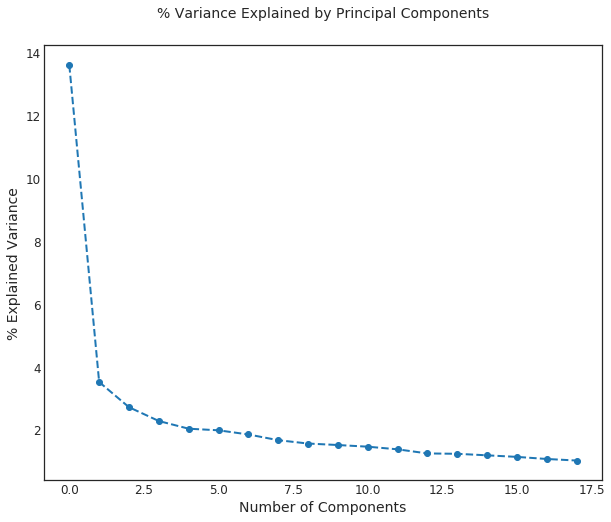

In [34]:
sns.set_style('white')
plt.figure(1, figsize=(10, 8))
plt.clf()
plt.plot(pca.explained_variance_,'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.legend()
### Comment to save the plot
# plt.savefig('A1.jpeg',dpi=1200)
plt.show()


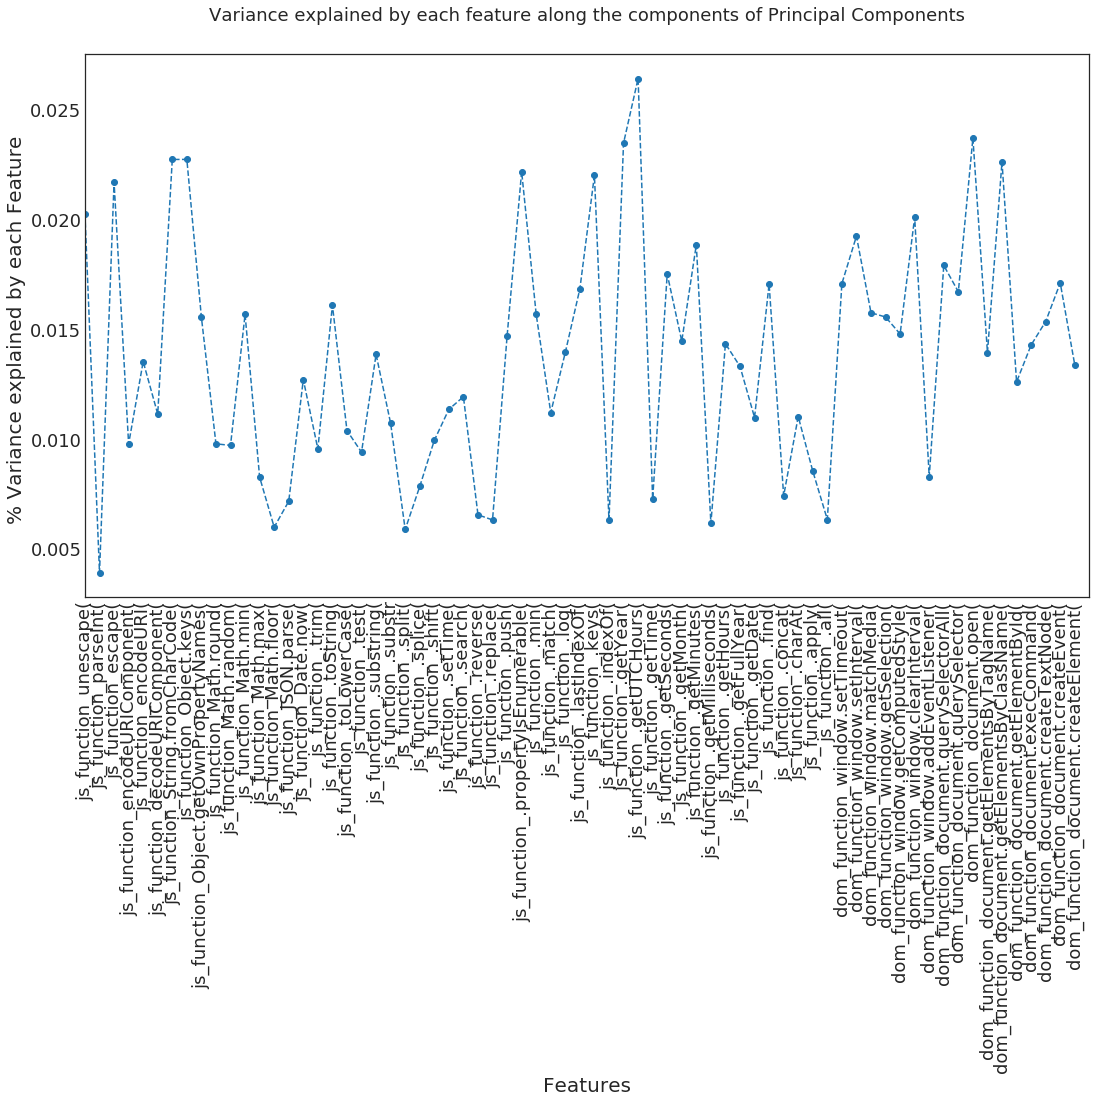

In [35]:
fig = plt.figure(figsize=(18, 10))
plt.plot(np.square(pca_inv_data.std(axis=0)), '--o')
plt.legend(loc='lower right')
plt.ylabel('% Variance explained by each Feature ', fontsize=20)
plt.xlabel('Features', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xlim([0, X.shape[1]])
plt.xticks(np.arange(X.shape[1]),feature_name,rotation=90)
plt.title('Variance explained by each feature along the components of Principal Components',size=18,y=1.05)
plt.legend(loc='upper right', fontsize=18)
# plt.savefig('B.jpeg',dpi=1200,bbox_inches = 'tight')
plt.show()

In [36]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')